# Using Survey Data as a Predictor of Pandemic Vaccination
## 3 - Clustering

### Mark Patterson, March 2021 

## Clustering of h1n1 survey data
Following the classification modeling, the next step is to look for additional patterns that may help identify who did or did not get vaccinated. In this step we are interested in seeing what clusters emerge from the survey data set. Will it group along types of questions in the survey? Or will it (hopefully) break into segments of people based on overall combinations of factors? Or will it be able to detect vax versus non-vax recipients? 

### Import Libraries and Load Data

In [2]:
# Import the relevant libraries
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from scipy.cluster.hierarchy import dendrogram, ward

%matplotlib inline
# Increase column width to display df
pd.set_option('display.max_columns', None)

## Initial Clustering with Approach A Data
Recall that initial modeling was done with a dataset that did not use one-hot encoding, and instead reated all features as ordinal. I did several runs on Clustering using this data-set - importing df5.csv. K-Means clustering with 4 clusters was used and then an HAC model with 2 clusters was also run. That approach was abandoned, and instead, I imported the Approach B data. This is described below. 

In [45]:
# Creating 7 lists of conceptually similar features. For cycling through plotting
pcols_1 = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']
pcols_2 = ['opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc']
pcols_3 = ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months']
pcols_4 = ['behavioral_antiviral_meds', 'behavioral_avoidance','behavioral_face_mask', 'behavioral_wash_hands','behavioral_large_gatherings', 'behavioral_outside_home','behavioral_touch_face']
pcols_5 = ['sex_num', 'age_group', 'education', 'race', 'marital_status']
pcols_6 = ['employment_status', 'health_worker', 'income_poverty', 'rent_or_own']
pcols_7 = ['hhs_geo_region_num', 'household_adults', 'household_children']

## Attempt 2 with Clustering - Data Prep Approach B w/ cut down dataframe
For this round of clustering I am utilizing a dataframe that included both one-hot encoding of some categorical variables and column value encoding for other variables (when they truly were ordinal). Then KNN Imputing was used to address the missing values. Standard Scaler was used to ensure the features were of the same magnitude. Finally, the origianl DF with 72 features was cut down to the most important features (identified via Random Forest modeling) which includes 19 features. 

In [61]:
# Load the previously shaped data and take a look.
df19C = pd.read_csv('data/df2_im_scal_19.csv')
print(df19C.shape)
df19C.head()

(26707, 20)


,Unnamed: 0,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty
0,0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
1,1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
2,2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154
3,3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
4,4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154


In [62]:
# drop the unecesary first column.
df19C = df19C.drop(columns=['Unnamed: 0'], axis=1)
df19C.shape

(26707, 19)

In [63]:
X_train = df19C.values

### K-Means clustering with 3 clusters
Based on earlier runs of clustering I felt 3 was a reasonable number of clusters. NOTE that this run of clustering is with the full dataset - both those who got vaccinated for H1N1 and those that didnt. 

In [64]:
k_means = KMeans(n_clusters=3)
k_means.fit(X_train)
predicted_clusters = k_means.predict(X_train)
print("The clusters are:", k_means.labels_)
print("The inertia score is:", k_means.inertia_)

The clusters are: [2 0 2 ... 0 2 2]
The inertia score is: 423478.39990249794


In [65]:
# Want to get a count of nuber of records per cluster
unique, counts = np.unique(predicted_clusters, return_counts=True)
counts = counts.reshape(1,3)
countscldf = pd.DataFrame(counts, columns=['cluster_0', 'cluster_1', 'cluster_2'])
countscldf

,cluster_0,cluster_1,cluster_2
0,8113,6573,12021


In [66]:
# Look at the inertia score for various values of k to identify best number of clusters.
no_of_clusters = range(2,20)
inertia = []

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("The inerta for:", f, "clusters is:", u)

The inerta for: 2 clusters is: 455302.3504063671
The inerta for: 3 clusters is: 423479.2116751037
The inerta for: 4 clusters is: 395981.94809310965
The inerta for: 5 clusters is: 378375.0996337224
The inerta for: 6 clusters is: 362847.4341601973
The inerta for: 7 clusters is: 349870.0486879499
The inerta for: 8 clusters is: 339741.495400871
The inerta for: 9 clusters is: 330485.7205681158
The inerta for: 10 clusters is: 323942.93790775404
The inerta for: 11 clusters is: 317446.6205196062
The inerta for: 12 clusters is: 312461.29041765514
The inerta for: 13 clusters is: 307042.63585104473
The inerta for: 14 clusters is: 302110.6669158055
The inerta for: 15 clusters is: 297888.3569961508
The inerta for: 16 clusters is: 294386.29525038373
The inerta for: 17 clusters is: 290169.72176907776
The inerta for: 18 clusters is: 287065.3196844167
The inerta for: 19 clusters is: 283392.6874529617


Text(0.5, 1.0, 'Best K for the Model')

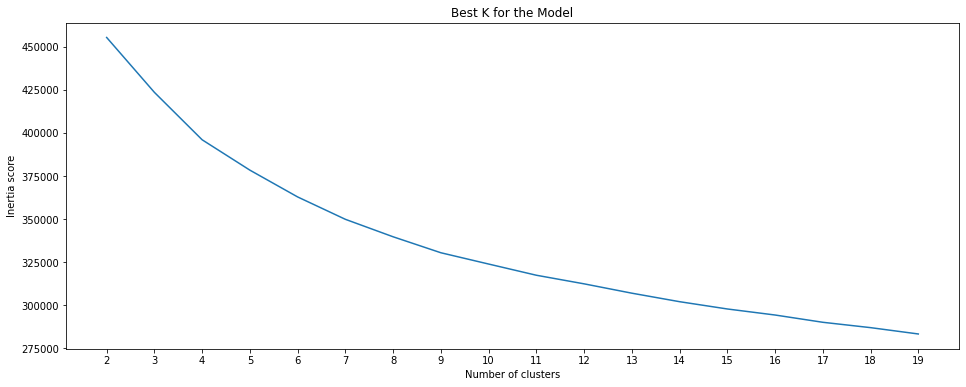

In [67]:
# Plotting the inertia score for various K values
fig,(ax1)=plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia score")
plt.title("Best K for the Model")

#### Observations on this KMeans cluster attemp
Based on a previous run of clustering, 4 seemed like too many clusters so this time went with 3. However, from looking at the inertia values and the elbow plot above - it seems like 4 is being suggested. Will also try plotting an HAC dendrogram to see if that is suggesting something different.

The HAC dendrogram (below) seems to be suggesting 5 clusters... but I could also see the 3 clusters on the right belonging together, and the one on the left may just be some outliers or misc group? 

Text(0.5, 1.0, 'Initial dendrogram to determine number of clusters')

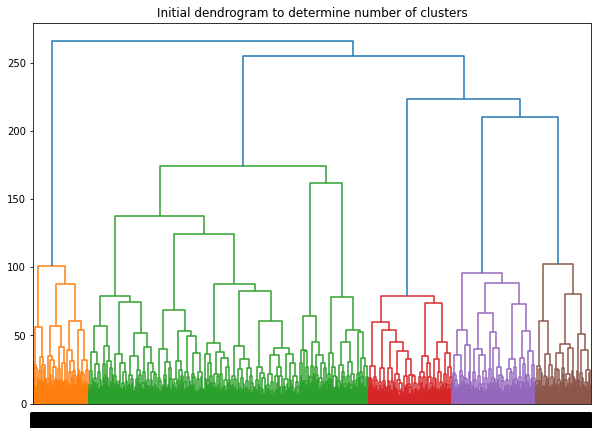

In [68]:
# Step to view dendrogram first, in order to see how many clusters to use for HAC
plt.figure(figsize=(10,7))
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
plt.title('Initial dendrogram to determine number of clusters')

In [69]:
# Rerunning the K-Means with 4 clusters. 
k_means = KMeans(n_clusters=4)
k_means.fit(X_train)
predicted_clusters = k_means.predict(X_train)
print("The clusters are:", k_means.labels_)
print("The inertia score is:", k_means.inertia_)

The clusters are: [0 0 2 ... 3 2 2]
The inertia score is: 395977.8975838526


In [70]:
# Want to get a count of nuber of records per cluster
unique, counts = np.unique(predicted_clusters, return_counts=True)
counts = counts.reshape(1,4)
countscldf = pd.DataFrame(counts, columns=['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3'])
countscldf

,cluster_0,cluster_1,cluster_2,cluster_3
0,2726,6606,10122,7253


In [71]:
# Attach the cluster labels back to the full df. 
clusters = k_means.labels_
df19C['Clusters-B4'] = clusters
df19C.head(5)

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2


In [73]:
# Load the df with Y features to reattach to this? NOTE this is just importated to grab the Y variables. 
df_yforC = pd.read_csv('data/df2_all_numerical.csv')
print(df_yforC.shape)
df_yforC.head()

(26707, 75)


,Unnamed: 0,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,marital_status,rent_or_own,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,race__Black,race__Hispanic,race__Other or Multiple,race__White,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,EMP__Employed,EMP__Not_Labor,EMP__Unemployed,GEO__atmpeygn,GEO__bhuqouqj,GEO__dqpwygqj,GEO__fpwskwrf,GEO__kbazzjca,GEO__lrircsnp,GEO__lzgpxyit,GEO__mlyzmhmf,GEO__oxchjgsf,GEO__qufhixun,MSA_Not_Principle_City,MSA_Principle_City,MSA_Not,INDUST__arjwrbjb,INDUST__atmlpfrs,INDUST__cfqqtusy,INDUST__dotnnunm,INDUST__fcxhlnwr,INDUST__haxffmxo,INDUST__ldnlellj,INDUST__mcubkhph,INDUST__mfikgejo,INDUST__msuufmds,INDUST__nduyfdeo,INDUST__phxvnwax,INDUST__pxcmvdjn,INDUST__qnlwzans,INDUST__rucpziij,INDUST__saaquncn,INDUST__vjjrobsf,INDUST__wlfvacwt,INDUST__wxleyezf,INDUST__xicduogh,INDUST__xqicxuve
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,3,0.0,0,0.0,1.0,0.0,0.0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,3.0,3.0,3.0,1.0,3.0,1,1.0,1,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,2.0,0.0,0.0,3.0,0.0,1.0,0,3.0,1,0.0,1.0,2.0,0.0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,2.0,2.0,4.0,4.0,3.0,0.0,4,1.0,0,0.0,0.0,0.0,0.0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,2.0,1.0,2.0,0.0,3.0,2,2.0,0,1.0,1.0,1.0,0.0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [74]:
# Wondering if I can copy out 1 column and then do same as above with values?
y_h1n1 = df_yforC['h1n1_vaccine']
y_seasonal = df_yforC['seasonal_vaccine']

In [75]:
# Attach the y back to the full df. 
df19C['H1n1_vaccine'] = y_h1n1
df19C.head(5)

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0


In [78]:
# Attach the y back to the full df. 
df19C['Seasonal_vaccine'] = y_seasonal
df19C.head(5)

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0


In [79]:
# Look at clusters in relation to each feature (mean values per cluster) and try and interpret.
result = df19C.groupby(["Clusters-B4"]).mean().transpose()
result

Clusters-B4,0,1,2,3
h1n1_concern,0.217838,-0.074049,-0.447768,0.610458
h1n1_knowledge,-0.487801,0.357754,-0.189497,0.121951
doctor_recc_h1n1,0.030047,-0.023751,-0.365961,0.521061
doctor_recc_seasonal,-0.033488,-0.061986,-0.341733,0.545951
health_worker,-0.165161,0.156546,-0.146628,0.124122
health_insurance,-0.670566,0.302252,-0.102359,0.119586
opinion_h1n1_vacc_effective,-0.030780,0.149049,-0.367406,0.388553
opinion_h1n1_risk,0.214388,-0.013409,-0.549046,0.697864
opinion_h1n1_sick_from_vacc,0.292334,-0.139403,-0.358514,0.517423
opinion_seas_vacc_effective,-0.083545,0.059867,-0.333601,0.442434


In [80]:
# Take a look at these clusters visually... cycle through a few sets of features. 
# Creating lists of conceptually similar features.
pcols_a = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc']
pcols_b = ['opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc']
pcols_c = ['doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_worker', 'health_insurance']
pcols_d = ['age_group', 'education', 'household_adults', 'household_children', 'INC_75K_to_Poverty', 'INC_over_75K', 'INC_below_Poverty']

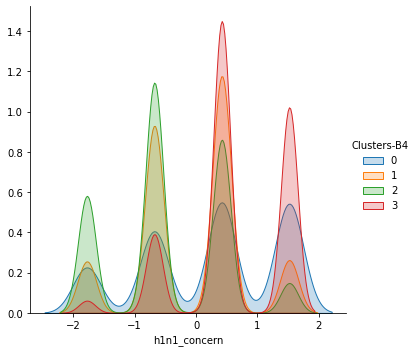

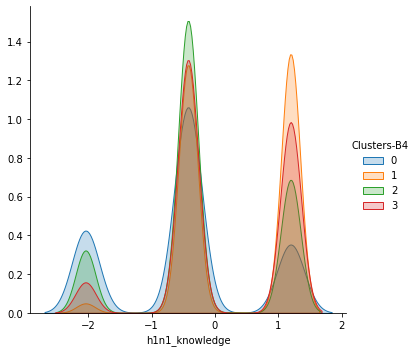

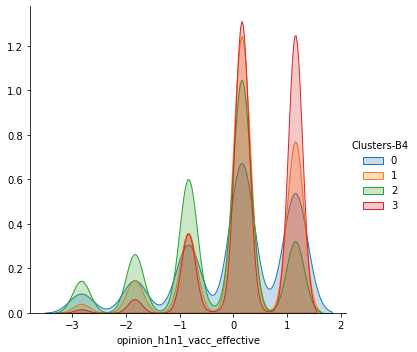

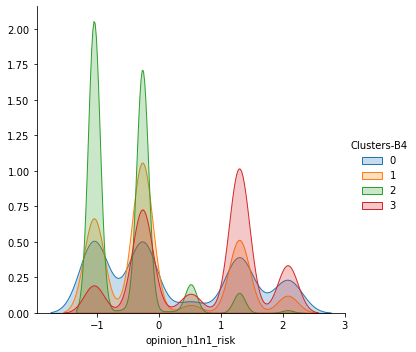

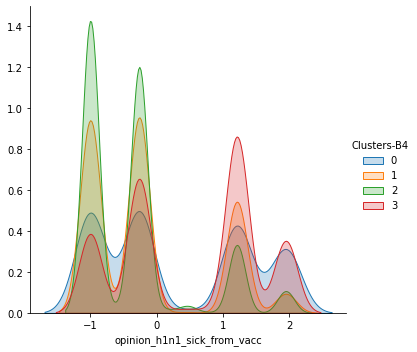

In [81]:
for p in pcols_a:
    (sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, p, shade=True).add_legend())

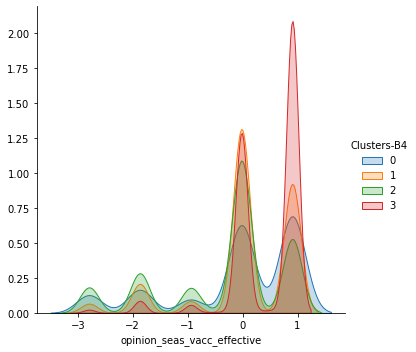

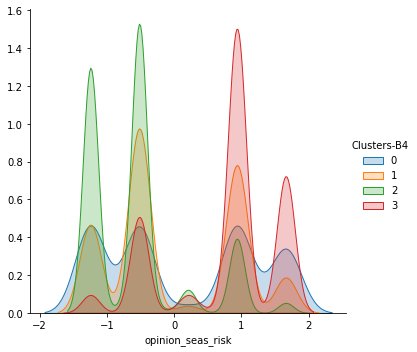

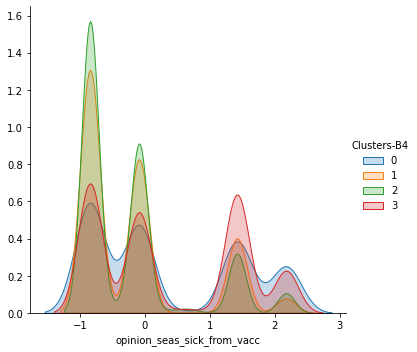

In [82]:
for p in pcols_b:
    (sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, p, shade=True).add_legend())

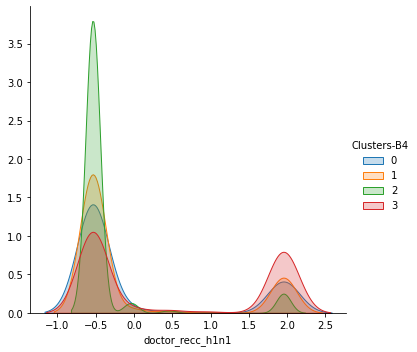

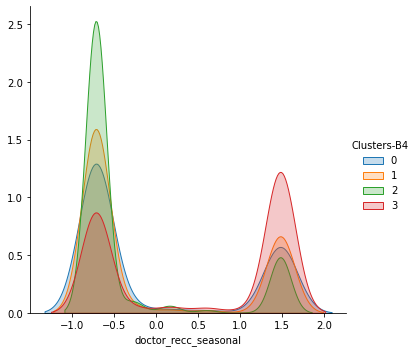

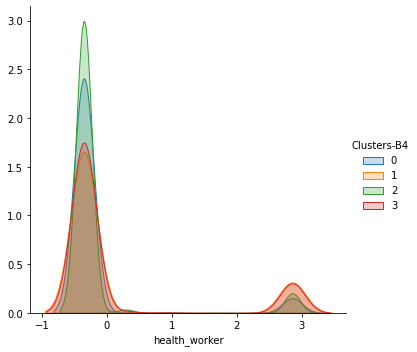

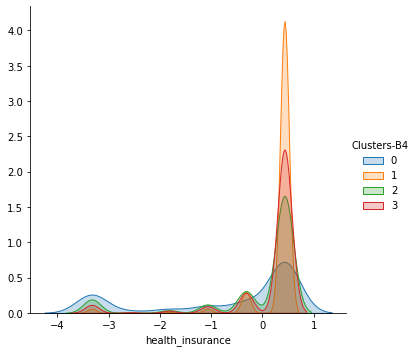

In [83]:
for p in pcols_c:
    (sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, p, shade=True).add_legend())

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


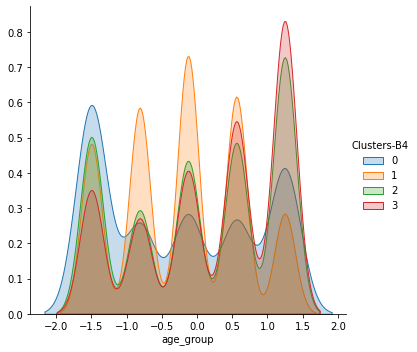

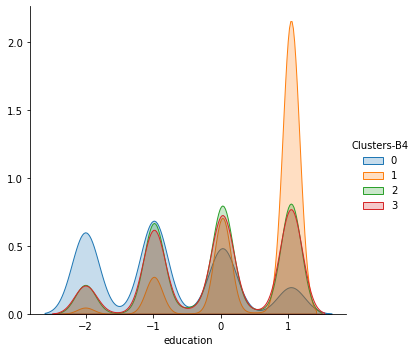

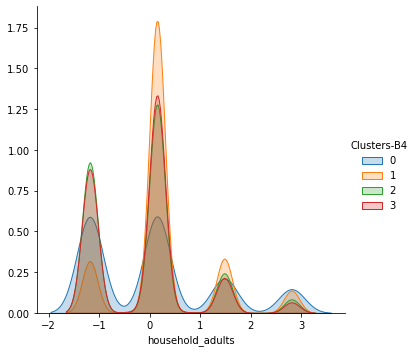

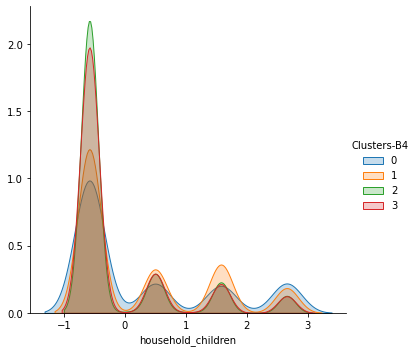

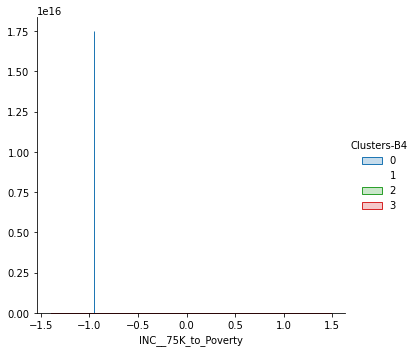

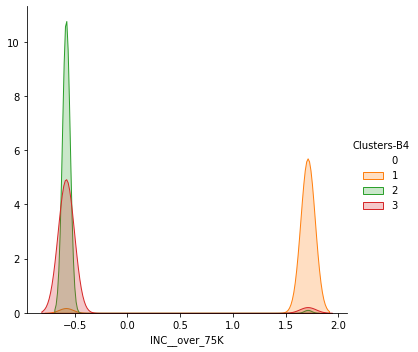

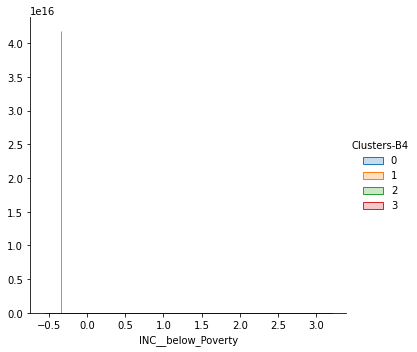

In [85]:
pcols_d = ['age_group', 'education', 'household_adults', 'household_children', 'INC__75K_to_Poverty', 'INC__over_75K', 'INC__below_Poverty']
for p in pcols_d:
    (sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, p, shade=True).add_legend())

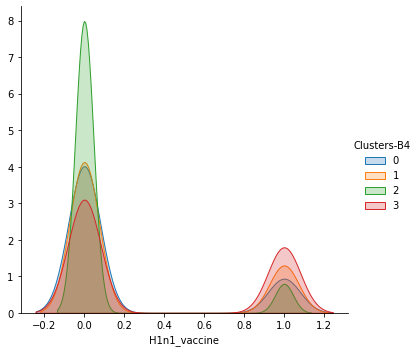

In [86]:
sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, 'H1n1_vaccine', shade=True).add_legend()

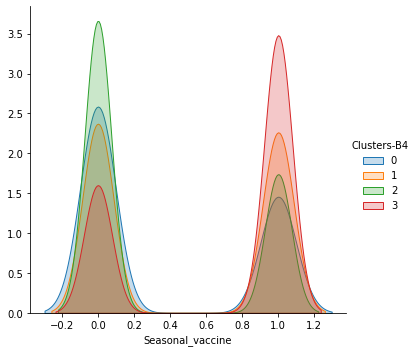

In [87]:
sns.FacetGrid(df19C, hue='Clusters-B4',height=5).map(sns.kdeplot, 'Seasonal_vaccine', shade=True).add_legend()

#### Observations: Approach B with the full dataset
With 4 clusters the plots are difficult to interpret. Decided to focus down more to JUST the records of people that did not get the H1N1 vaccine (class = 0). 

### Rerun the analysis with just the non-vax class (79% of dataset)
Decidded to focus on this subset of data. Perhaps there are other patterns once we remove the obvious ones from the full data set.

In [88]:
print(df19C.shape)
df19C.head(5)

(26707, 22)


,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0


In [89]:
df20C = df19C.loc[df19C['H1n1_vaccine'] == 0]
df20C.head()

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0


In [93]:
df20C['H1n1_vaccine'].value_counts()

0    21033
Name: H1n1_vaccine, dtype: int64

In [94]:
# Cutting down the columns to eliminate target ariables and previosu cluster results. 
columns_to_cut = ['Clusters-B4', 'H1n1_vaccine', 'Seasonal_vaccine']
df20C = df20C.drop(columns_to_cut, axis=1)
df20C.head()

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154


In [95]:
X_train = df20C.values

Text(0.5, 1.0, 'Initial dendrogram to determine number of clusters')

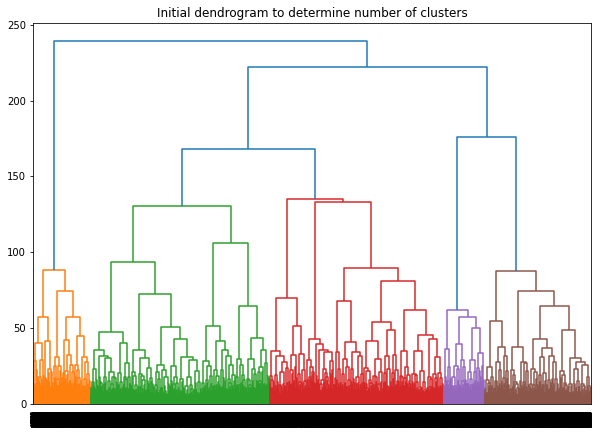

In [96]:
# Step to view dendrogram first, in order to see how many clusters to use for HAC
plt.figure(figsize=(10,7))
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
plt.title('Initial dendrogram to determine number of clusters')

#### Observations on the dendrogram
It is suggesting 5 clusters, however the purple and orange clusters are fairly small. I am going to move forward with 3 clusters. 

In [97]:
# K-Means clustering with 3 clusters (class 0 dataset)
k_means = KMeans(n_clusters=3)
k_means.fit(X_train)
predicted_clusters = k_means.predict(X_train)
print("The clusters are:", k_means.labels_)
print("The inertia score is:", k_means.inertia_)

The clusters are: [1 2 1 ... 2 1 1]
The inertia score is: 322195.6921531434


In [98]:
# Want to get a count of nuber of records per cluster
unique, counts = np.unique(predicted_clusters, return_counts=True)
counts = counts.reshape(1,3)
countscldf = pd.DataFrame(counts, columns=['cluster_0', 'cluster_1', 'cluster_2'])
countscldf

,cluster_0,cluster_1,cluster_2
0,5057,10144,5832


In [99]:
df19C.head()

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0


In [100]:
df21C = df19C.loc[df19C['H1n1_vaccine'] == 0]
df21C.shape

(21033, 22)

In [101]:
# Attach the cluster labels back to the full df. 
clusters = k_means.labels_
df21C['Clusters-non-vac-3'] = clusters
df21C.head(5)

/Users/markp/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine,Clusters-non-vac-3
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0,1
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1,2
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0,1
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1,2
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0,1


In [102]:
# Look at clusters in relation to each feature (means) and try and interpret.
result = df21C.groupby(["Clusters-non-vac-3"]).mean().transpose()
result

Clusters-non-vac-3,0,1,2
h1n1_concern,-0.135410,-0.467220,0.702262
h1n1_knowledge,0.290162,-0.147080,-0.216925
doctor_recc_h1n1,-0.213536,-0.336804,0.038623
doctor_recc_seasonal,-0.160369,-0.235570,0.153987
health_worker,0.013073,-0.137007,-0.089378
health_insurance,0.281146,-0.075627,-0.296357
opinion_h1n1_vacc_effective,-0.011508,-0.370663,0.151057
opinion_h1n1_risk,-0.239228,-0.572697,0.600649
opinion_h1n1_sick_from_vacc,-0.187339,-0.424092,0.758624
opinion_seas_vacc_effective,-0.054251,-0.304118,0.238479


In [ ]:
# Also running the full series of plots for all features for visual interpretation. 

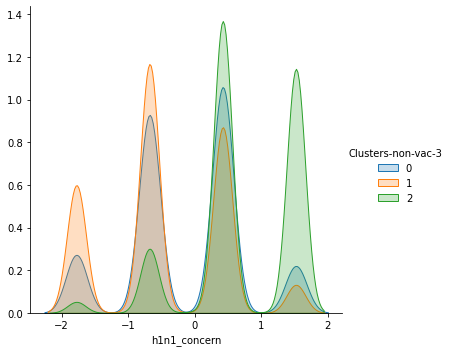

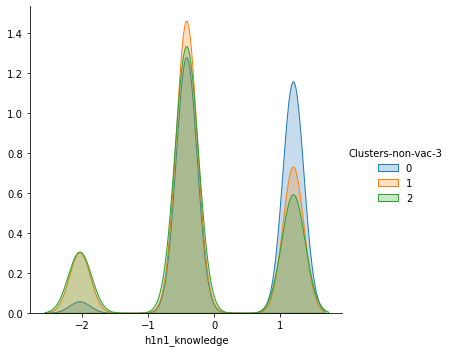

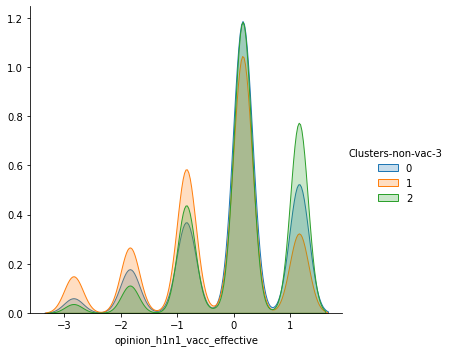

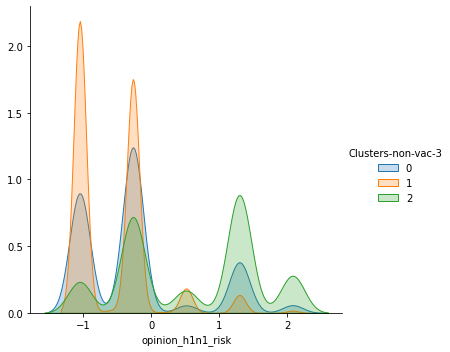

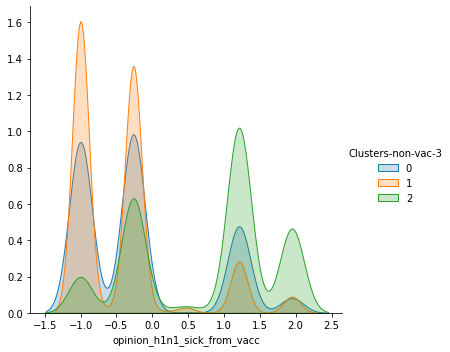

In [103]:
for p in pcols_a:
    (sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

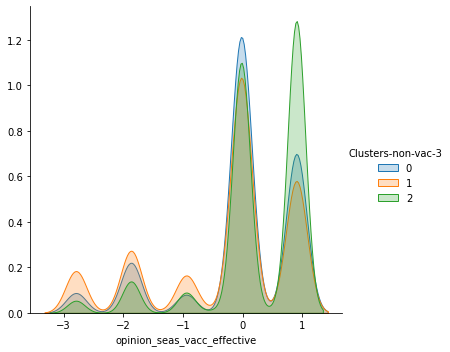

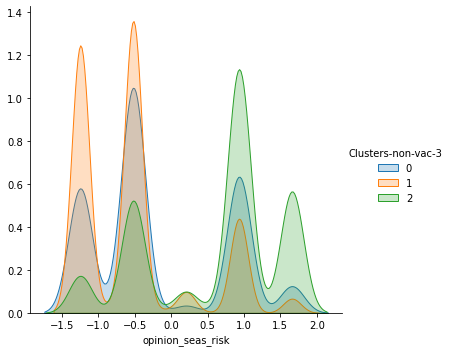

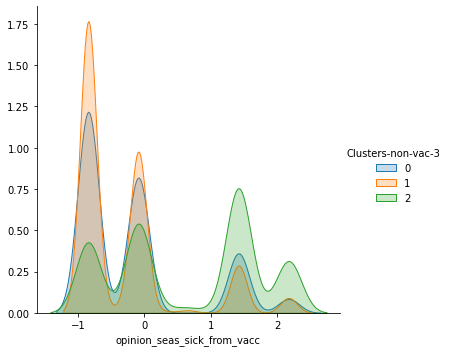

In [104]:
for p in pcols_b:
    (sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

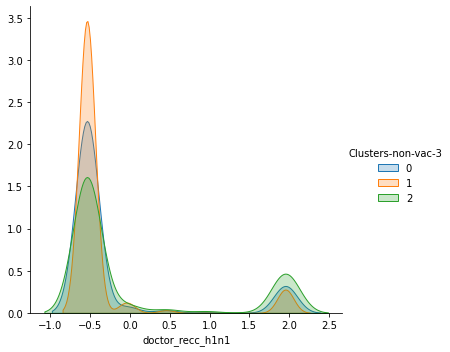

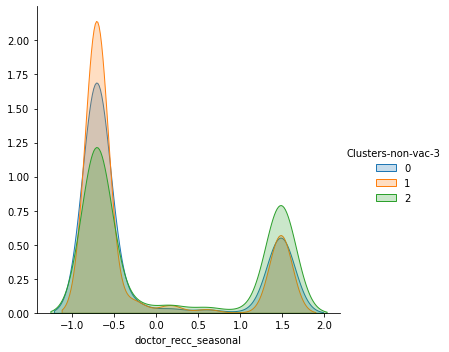

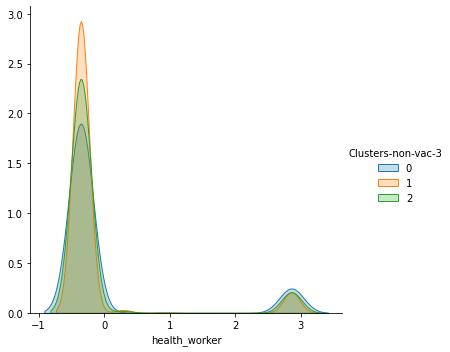

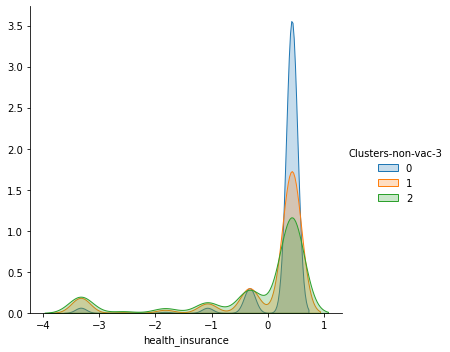

In [105]:
for p in pcols_c:
    (sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

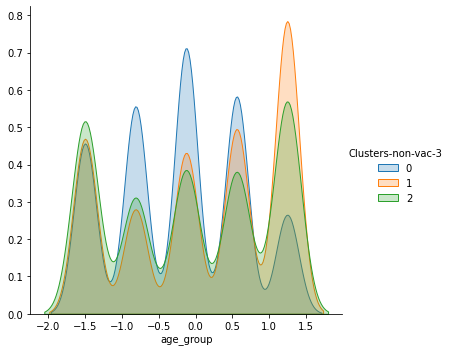

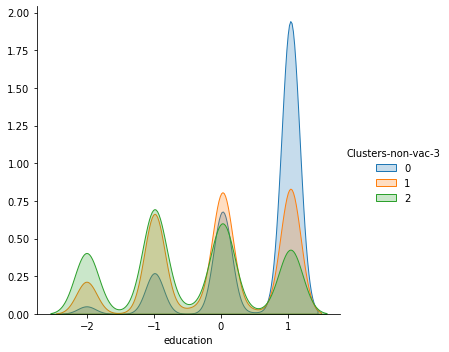

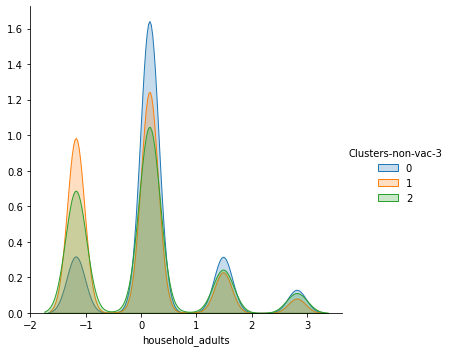

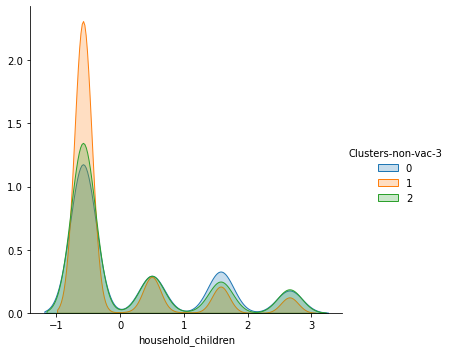

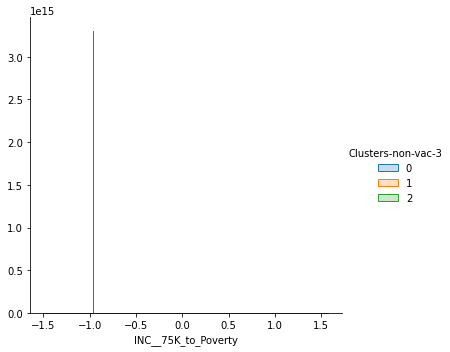

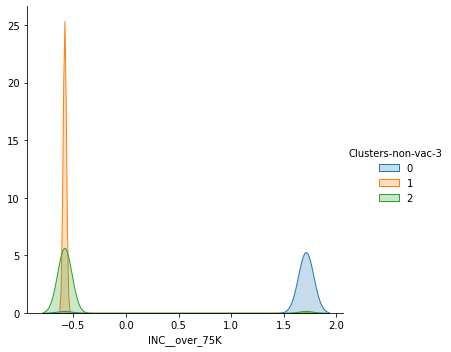

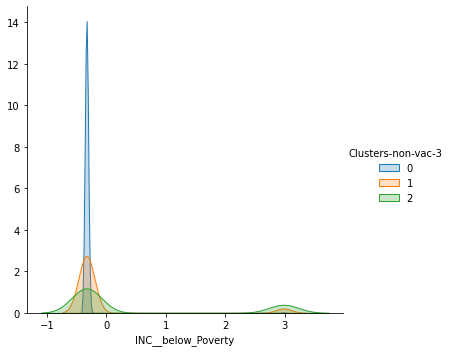

In [106]:
pcols_d = ['age_group', 'education', 'household_adults', 'household_children', 'INC__75K_to_Poverty', 'INC__over_75K', 'INC__below_Poverty']
for p in pcols_d:
    (sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

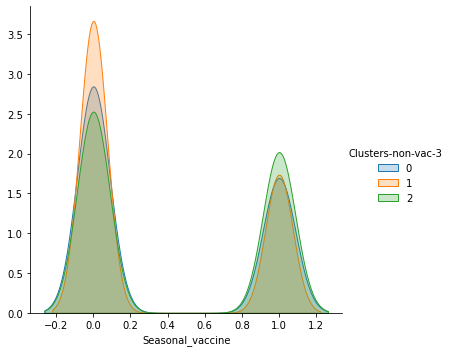

In [108]:
sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, 'Seasonal_vaccine', shade=True).add_legend()

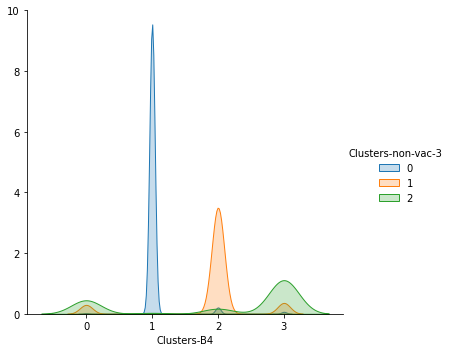

In [109]:
sns.FacetGrid(df21C, hue='Clusters-non-vac-3',height=5).map(sns.kdeplot, 'Clusters-B4', shade=True).add_legend()

#### Observations on K-means clustering with 3 clusters
Looking at the plots shows some interesting distinctions between the clusters. 
* Group 1: older, less contact with others, feel less at risk, lower doctor recommended 
* Group 0: younger (18-34) more concerned about risks
* Group 2: more contact with others in home; higher income and education / knowledge; but lower to med on opinion questions. 
Group 1 makes sense as people over 65 were less at risk of catching the H1N1 virus. These findings help to corroborate what we saw in the modeling - in terms of feature importance. 

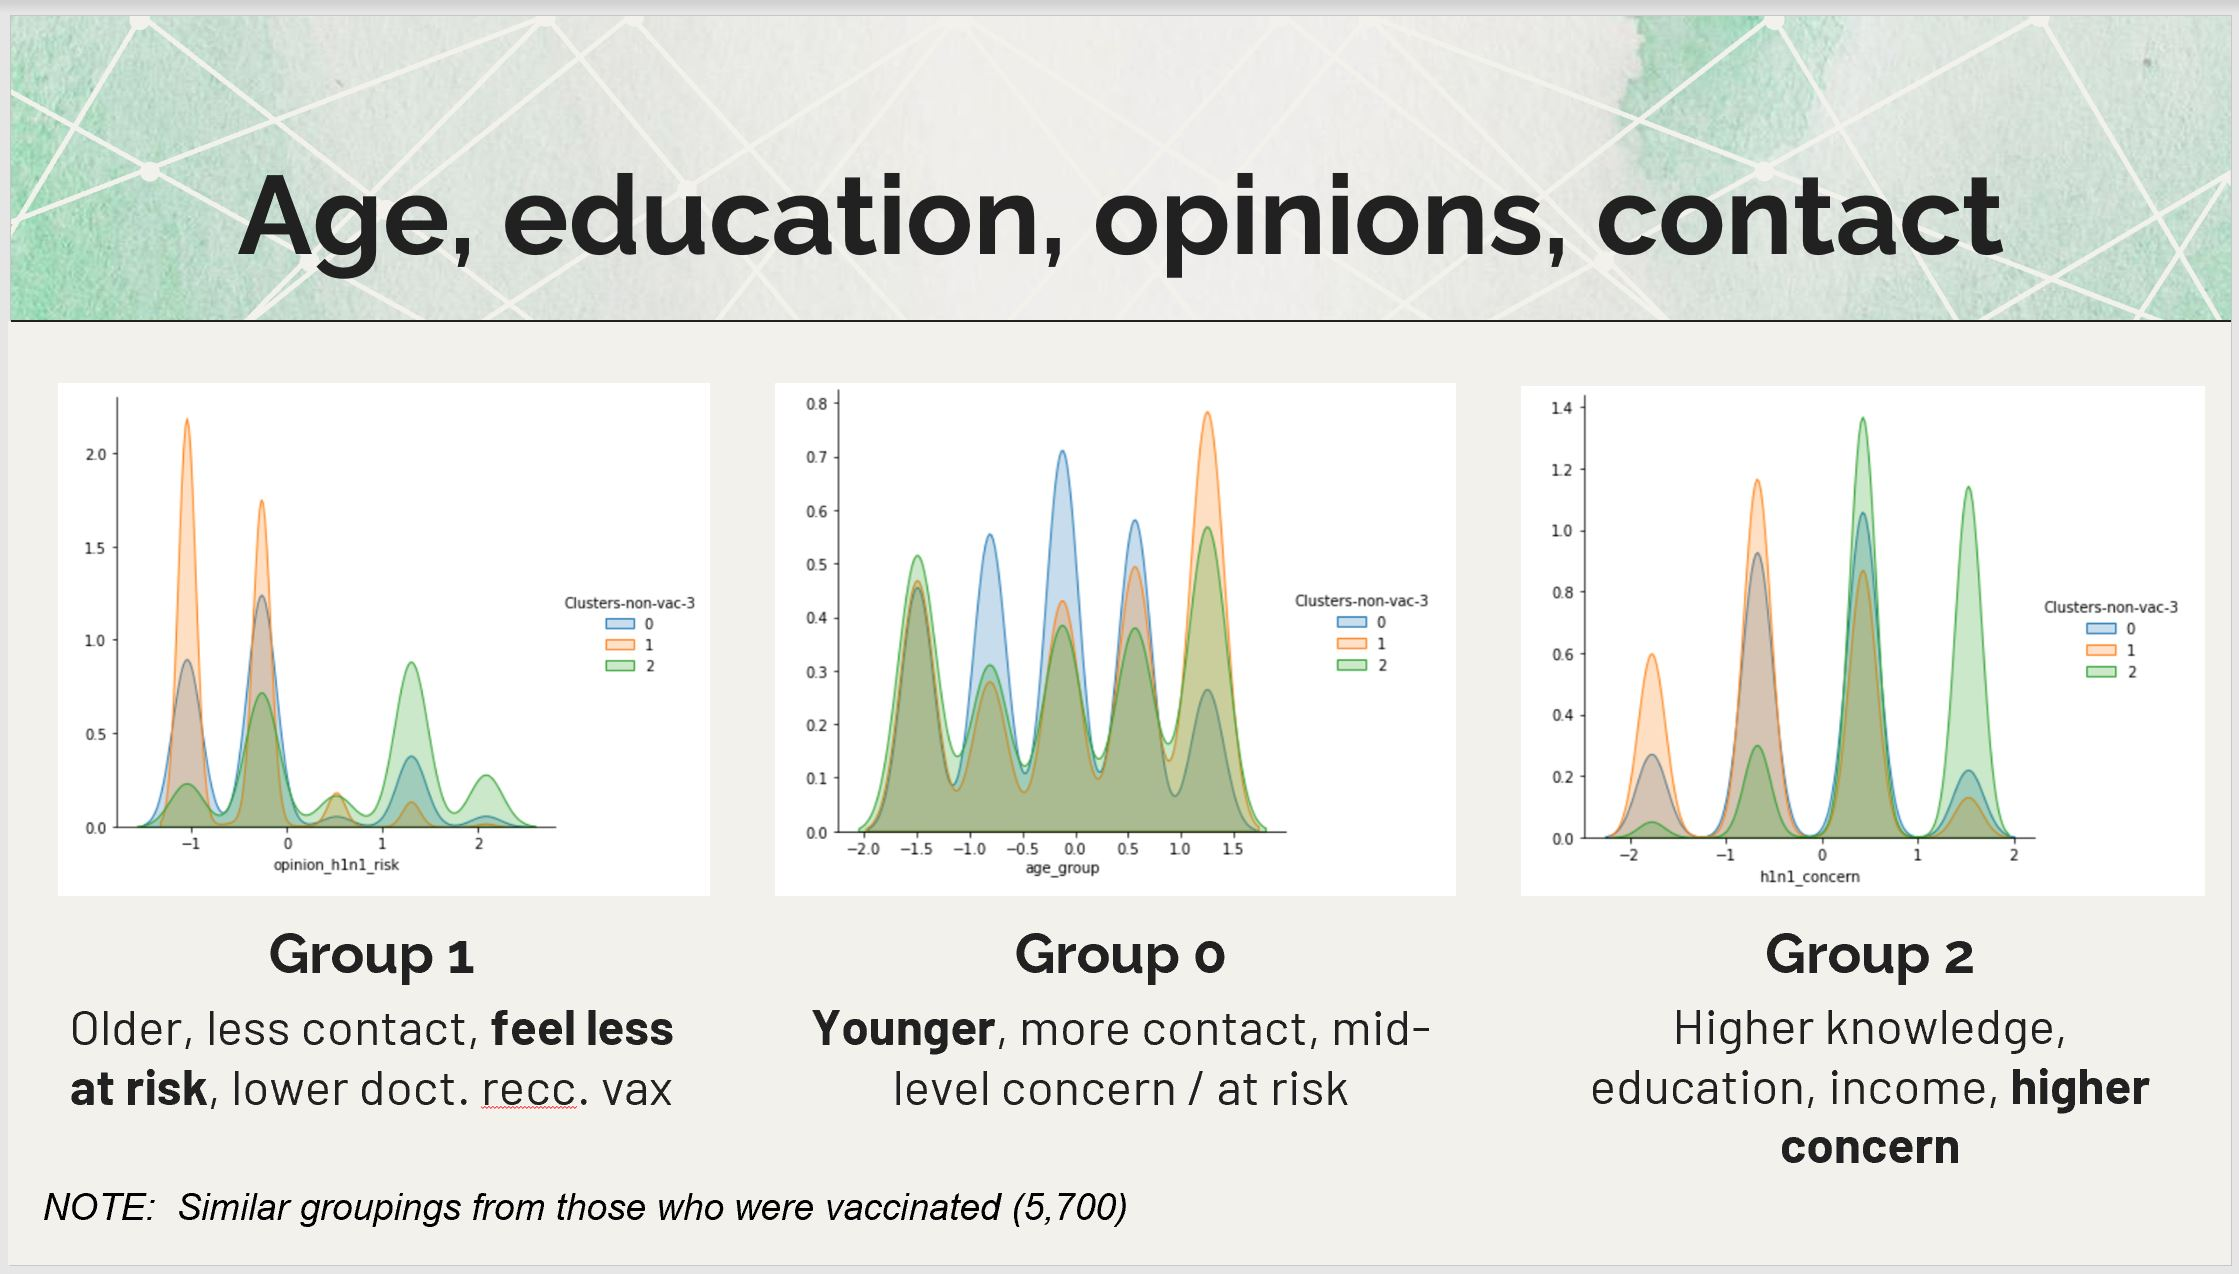

### Also cluster with the subset of people who GOT Vaccinated for H1n1 (21%)
Interested to see if there are any big differences. 

In [110]:
print(df19C.shape)
df19C.head(5)

(26707, 22)


,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
0,-0.679477,-2.043782,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-1.048700,-0.264324,-1.869153,-1.245424,-0.090271,0.558480,-2.006398,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,0
1,1.519841,1.196063,-0.538812,-0.714456,-0.354921,0.429421,1.150052,1.296788,1.210360,-0.019914,-0.519056,1.420485,-0.813928,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
2,-0.679477,-0.423859,-0.538812,-0.714456,-0.354921,-1.074749,-0.844586,-1.048700,-1.001667,-0.019914,-1.245424,-0.090271,-1.500131,1.041938,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,0,0
3,-0.679477,-0.423859,-0.538812,1.477700,-0.354921,0.429421,-0.844586,0.514959,1.947702,0.904706,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,-0.957721,-0.585032,2.983703,0,0,1
4,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,0.514959,-0.264324,-0.944533,-1.245424,1.420485,-0.127724,0.025826,0.149666,-0.582158,1.044146,-0.585032,-0.335154,2,0,0


In [111]:
df21C = df19C.loc[df19C['H1n1_vaccine'] == 1]
df21C.head()

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-B4,H1n1_vaccine,Seasonal_vaccine
7,-0.679477,-2.043782,1.953490,-0.714456,-0.354921,0.429421,1.150052,-0.266871,-1.001667,-0.019914,-0.519056,-0.845649,-0.127724,0.025826,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,1,1
10,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,-3.331004,0.152733,-1.048700,-0.264324,0.904706,0.933679,1.420485,-0.127724,-0.990286,1.481332,-0.582158,1.044146,-0.585032,-0.335154,2,1,1
11,-0.679477,1.196063,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-0.266871,-0.264324,-0.019914,-0.519056,-0.845649,0.558480,1.041938,0.149666,1.576705,-0.957721,1.709308,-0.335154,1,1,1
16,0.420182,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,-1.001667,-0.019914,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,1.044146,-0.585032,-0.335154,3,1,1
26,1.519841,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,1.210360,0.904706,1.660047,1.420485,-0.127724,1.041938,0.149666,1.576705,-0.957721,-0.585032,-0.335154,3,1,1


In [112]:
df21C['H1n1_vaccine'].value_counts()

1    5674
Name: H1n1_vaccine, dtype: int64

In [113]:
# Cutting down the columns
columns_to_cut = ['Clusters-B4', 'H1n1_vaccine', 'Seasonal_vaccine']
df21C = df21C.drop(columns_to_cut, axis=1)
df21C.head()

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty
7,-0.679477,-2.043782,1.953490,-0.714456,-0.354921,0.429421,1.150052,-0.266871,-1.001667,-0.019914,-0.519056,-0.845649,-0.127724,0.025826,1.481332,-0.582158,1.044146,-0.585032,-0.335154
10,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,-3.331004,0.152733,-1.048700,-0.264324,0.904706,0.933679,1.420485,-0.127724,-0.990286,1.481332,-0.582158,1.044146,-0.585032,-0.335154
11,-0.679477,1.196063,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-0.266871,-0.264324,-0.019914,-0.519056,-0.845649,0.558480,1.041938,0.149666,1.576705,-0.957721,1.709308,-0.335154
16,0.420182,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,-1.001667,-0.019914,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,1.044146,-0.585032,-0.335154
26,1.519841,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,1.210360,0.904706,1.660047,1.420485,-0.127724,1.041938,0.149666,1.576705,-0.957721,-0.585032,-0.335154


In [114]:
df21C.shape

(5674, 19)

In [115]:
X_train = df21C.values

Text(0.5, 1.0, 'Initial dendrogram to determine number of clusters (vax = yes)')

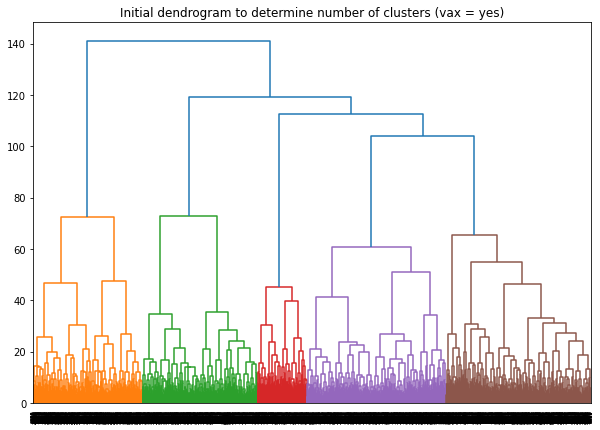

In [116]:
# Step to view dendrogram first, in order to see how many clusters to use for HAC
plt.figure(figsize=(10,7))
dendrogram = sch.dendrogram(sch.linkage(X_train, method='ward'))
plt.title('Initial dendrogram to determine number of clusters (vax = yes)')

#### Observations on the dendrogram
Still suggesting 5 clusters, but distributed a bit differently. Here the red cluster is fairly small. There is also an interseting pattern to the way the branches grouped at the top level. More distinct groups moving from right to left.

In [117]:
# Run K-Means clustering with 3 clusters - to make it more directly comparable to the other set of data (class = 0).
k_means = KMeans(n_clusters=3)
k_means.fit(X_train)
predicted_clusters = k_means.predict(X_train)
print("The clusters are:", k_means.labels_)
print("The inertia score is:", k_means.inertia_)

The clusters are: [1 1 1 ... 1 2 2]
The inertia score is: 88656.48567981855


In [118]:
# Want to get a count of nuber of records per cluster
unique, counts = np.unique(predicted_clusters, return_counts=True)
counts = counts.reshape(1,3)
countscldf = pd.DataFrame(counts, columns=['cluster_0', 'cluster_1', 'cluster_2'])
countscldf

,cluster_0,cluster_1,cluster_2
0,1186,2173,2315


In [119]:
# Attach the cluster labels back to the full df. 
clusters = k_means.labels_
df21C['Clusters-VAC-3'] = clusters
df21C.head(5)

,h1n1_concern,h1n1_knowledge,doctor_recc_h1n1,doctor_recc_seasonal,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,INC__75K_to_Poverty,INC__over_75K,INC__below_Poverty,Clusters-VAC-3
7,-0.679477,-2.043782,1.953490,-0.714456,-0.354921,0.429421,1.150052,-0.266871,-1.001667,-0.019914,-0.519056,-0.845649,-0.127724,0.025826,1.481332,-0.582158,1.044146,-0.585032,-0.335154,1
10,0.420182,-0.423859,-0.538812,-0.714456,-0.354921,-3.331004,0.152733,-1.048700,-0.264324,0.904706,0.933679,1.420485,-0.127724,-0.990286,1.481332,-0.582158,1.044146,-0.585032,-0.335154,1
11,-0.679477,1.196063,-0.538812,-0.714456,-0.354921,0.429421,-0.844586,-0.266871,-0.264324,-0.019914,-0.519056,-0.845649,0.558480,1.041938,0.149666,1.576705,-0.957721,1.709308,-0.335154,1
16,0.420182,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,-1.001667,-0.019914,0.933679,-0.845649,1.244684,-0.990286,-1.182000,-0.582158,1.044146,-0.585032,-0.335154,2
26,1.519841,-0.423859,1.953490,1.477700,-0.354921,0.429421,-0.844586,-0.266871,1.210360,0.904706,1.660047,1.420485,-0.127724,1.041938,0.149666,1.576705,-0.957721,-0.585032,-0.335154,2


In [120]:
# Look at clusters in relation to each feature (mean) and try and interpret.
result = df21C.groupby(["Clusters-VAC-3"]).mean().transpose()
result

Clusters-VAC-3,0,1,2
h1n1_concern,0.245312,0.076165,0.376766
h1n1_knowledge,0.700525,0.046238,0.154834
doctor_recc_h1n1,0.688846,-0.380075,1.848845
doctor_recc_seasonal,0.367945,-0.461848,1.239641
health_worker,2.856957,-0.343980,-0.343818
health_insurance,0.258838,0.154960,0.185765
opinion_h1n1_vacc_effective,0.601106,0.413881,0.572339
opinion_h1n1_risk,0.900732,0.282029,0.792703
opinion_h1n1_sick_from_vacc,0.065179,0.016632,0.307394
opinion_seas_vacc_effective,0.351025,0.230538,0.454098


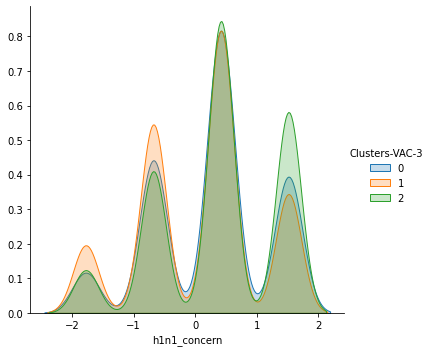

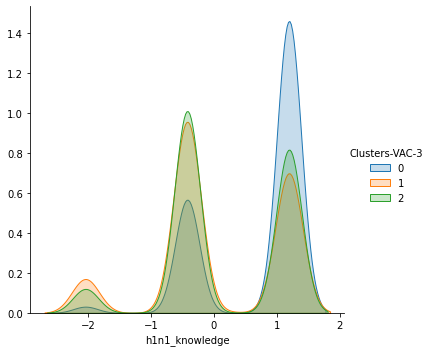

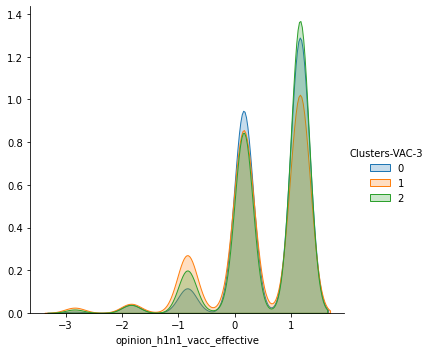

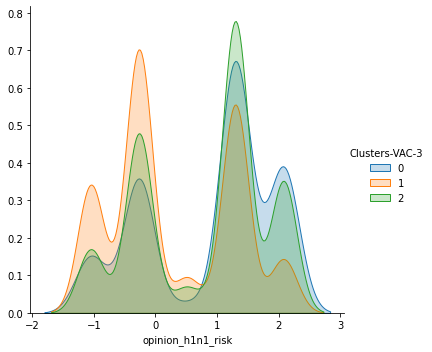

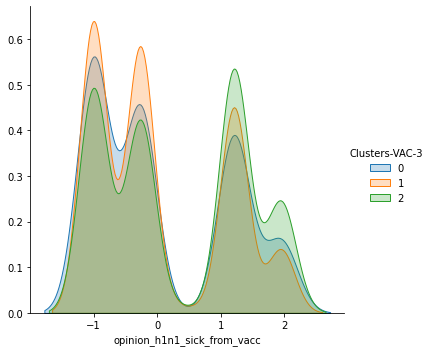

In [121]:
# Also plotting all features for easier visual intepretation. 
for p in pcols_a:
    (sns.FacetGrid(df21C, hue='Clusters-VAC-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

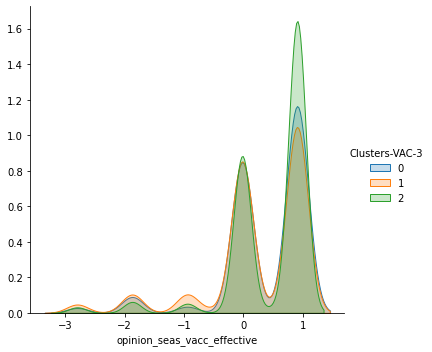

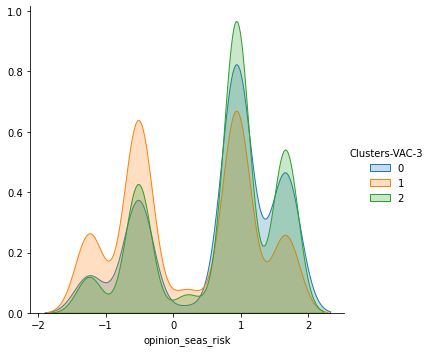

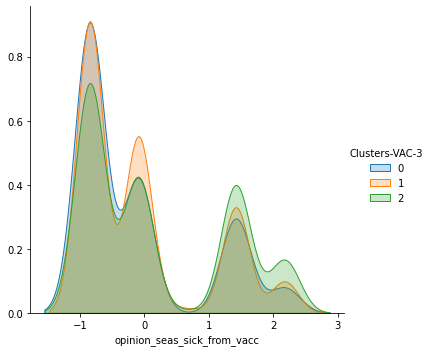

In [122]:
for p in pcols_b:
    (sns.FacetGrid(df21C, hue='Clusters-VAC-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

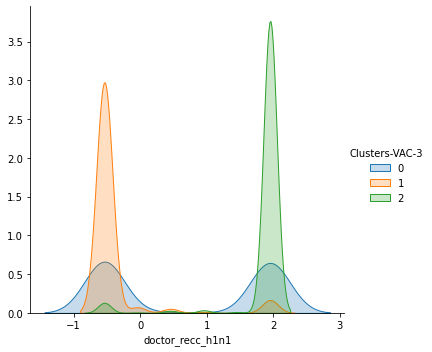

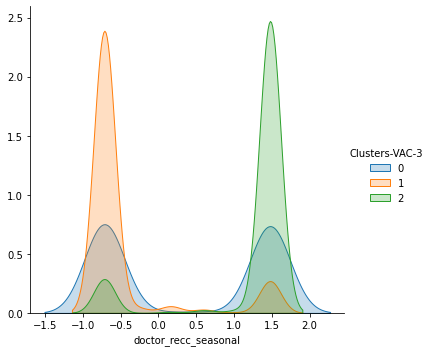

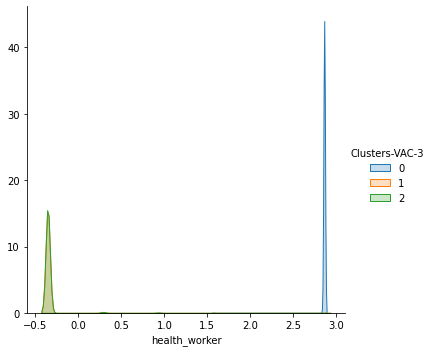

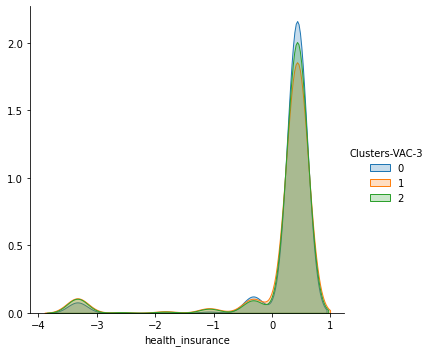

In [123]:
for p in pcols_c:
    (sns.FacetGrid(df21C, hue='Clusters-VAC-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

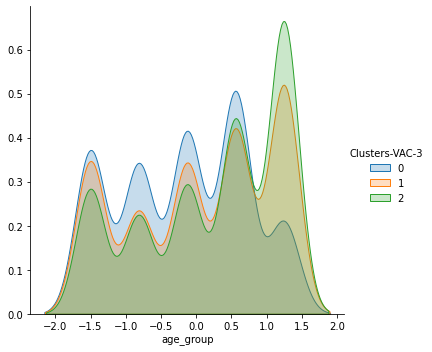

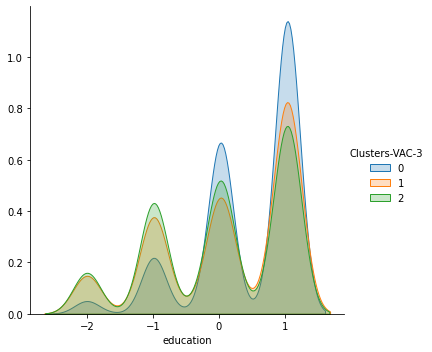

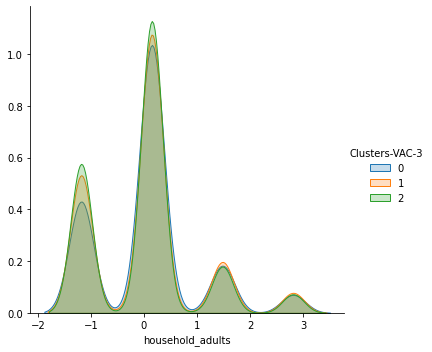

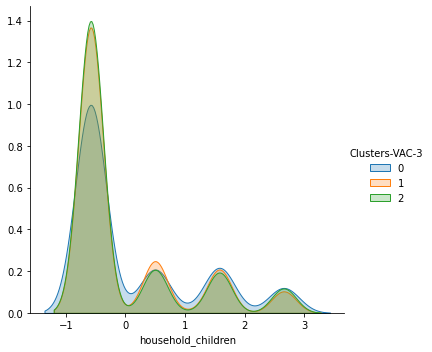

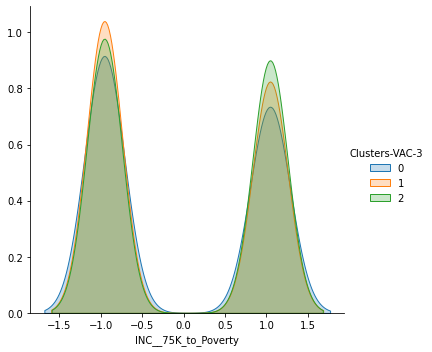

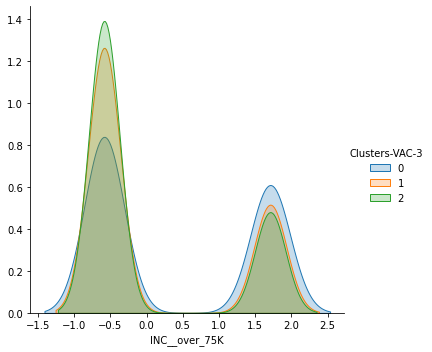

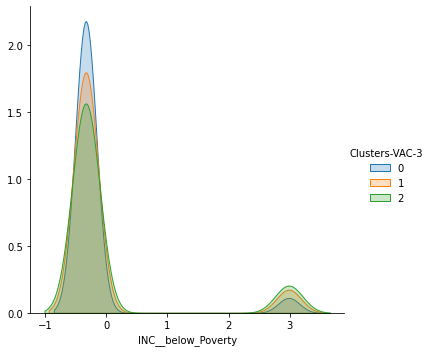

In [124]:
for p in pcols_d:
    (sns.FacetGrid(df21C, hue='Clusters-VAC-3',height=5).map(sns.kdeplot, p, shade=True).add_legend())

#### Observations on the clustering of class = 1 (people who got vaccinated)
The results were similar to the non-vaccinated group, but the mean values were different. Similar things stood out:
* Age-based (older and less at risk)
* Doctor recommended and strong positive opinions, feel at risk
* Educated, knowledgeable about h1n1, health worker, younger age groups < 65


In [125]:
# Curious to see what the inertia scores would suggest for number of clusters, 
# Look at the inertia score for various values of k to identify best number of clusters.
no_of_clusters = range(2,20)
inertia = []

for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("The inerta for:", f, "clusters is:", u)

The inerta for: 2 clusters is: 96407.05189269112
The inerta for: 3 clusters is: 88656.48567981855
The inerta for: 4 clusters is: 83171.31495269496
The inerta for: 5 clusters is: 78617.92106338264
The inerta for: 6 clusters is: 75498.23869006155
The inerta for: 7 clusters is: 72833.53475464947
The inerta for: 8 clusters is: 70108.33841676732
The inerta for: 9 clusters is: 68357.80374507113
The inerta for: 10 clusters is: 66997.35051318673
The inerta for: 11 clusters is: 65540.16280777409
The inerta for: 12 clusters is: 64562.817825088045
The inerta for: 13 clusters is: 63359.76103345601
The inerta for: 14 clusters is: 61989.793652077155
The inerta for: 15 clusters is: 61189.733942863604
The inerta for: 16 clusters is: 60184.18821283025
The inerta for: 17 clusters is: 59332.20045801561
The inerta for: 18 clusters is: 58294.02929757264
The inerta for: 19 clusters is: 57672.01555079321


Text(0.5, 1.0, 'Best K for the Model')

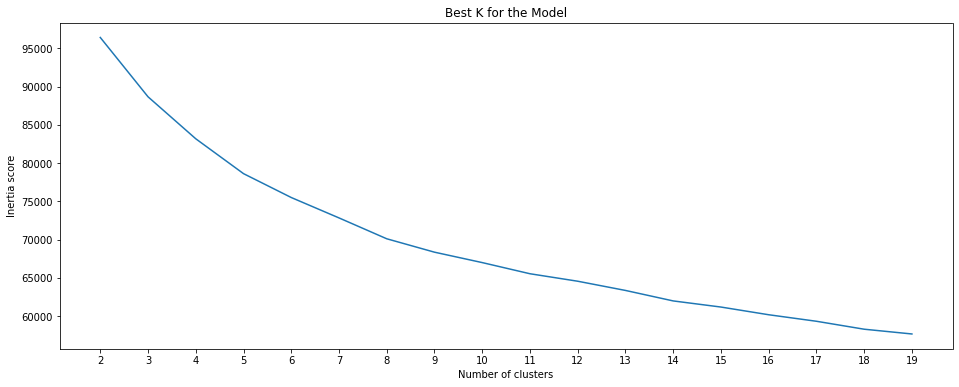

In [126]:
# Plotting the inertia score for various K values
fig,(ax1)=plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia score")
plt.title("Best K for the Model")

#### Observations on the number of clusters
It appears that either 3 or 5 are suggested via the elbo plot. 

## APPENDIX

In [46]:
import plotly.express as px

In [ ]:
# Potentil solution for running a set of plots? 
numeric_features=[x for x in data.columns if data[x].dtype!="object"]
#taking only the numeric columns from the dataframe.

for i in data[numeric_features].columns:
    plt.figure(figsize=(12,5))
    plt.title(i)
    sns.boxplot(data=data[i])

In [ ]:
# Another possible plotting option
profiles_file = 'data.csv'
df = pd.read_csv(profiles_file)

cols_to_plot = ['age', 'drinking', 'exercise', 'smoking']

fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.5)

for col, ax in zip(cols_to_plot, axs.flatten()):
    dftemp = df[col].value_counts()
    ax.bar(dftemp.index, list(dftemp))
    ax.set_title(col)
    ax.tick_params(axis='x', labelrotation=30)

plt.show()

In [ ]:
# Try a different style of viz. Grouped bar. 

In [31]:
# This code having trouble with countplot and catplot. 
# fig, ax = plt.subplots()

# sns.countplot("h1n1_vaccine", hue="education", data=df5, kind="count", 
#             palette={0:"blue",1:"yellow", 2:"orange", 3:"red"}, ax=ax)

# plt.close(2) # catplot creates an extra figure we don't need

# ax.legend(title="Education")
# ax.set_xticklabels(["not vacc", "vaccinated"])
# ax.set_xlabel("")

# fig.suptitle("Education vs. h1n1 vaccination");